In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 5
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2017-04-10', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


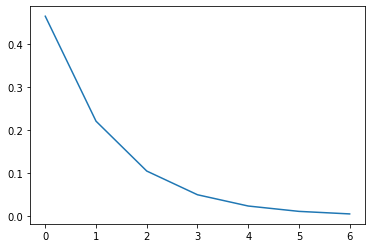

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                   Close                    High        ...  \
  ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
0   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
1   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
2   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
3   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
4   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN -0.020062            1.0            NaN   
1            NaN             NaN -0.007183            1.0       1.012962   
2            NaN             NaN  0.006624            1.0       1.013903   
3            NaN             NaN -0.005045            1.0       0.988398   
4            NaN             NaN -0.017959            1.0       0.987169   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN -0.020062            1.0            NaN             NaN  
1        1.012962 -0.007255            1.0       1.012889        1.012889  
2        1.013903  0.006488            1.0       1.013838        1.013838  
3        0.988398 -0.005286            1.0       0.988295        0.988295  
4        0.987169 -0.018029            1.0       0.987338        0.987338  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2513   2022-04-04
2514   2022-04-05
2515   2022-04-06
2516   2022-04-07
2517   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                   Close                    High        ...  \
     ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
Date                                                              ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

     DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
             ^W5000          ^W5000     mine1          mine1          mine1   
Date                                                                          
NaT             NaN             NaN -0.020062            1.0            NaN   
NaT             NaN             NaN -0.007183            1.0       1.012962   
NaT             NaN             NaN  0.006624            1.0       1.013903   
NaT             NaN             NaN -0.005045            1.0       0.988398   
NaT             NaN             NaN -0.017959            1.0       0.987169   

     OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
               mine1     mine2          mine2          mine2           mine2  
Date                                                                          
NaT              NaN -0.020062            1.0            NaN             NaN  
NaT         1.012962 -0.007255            1.0       1.012889        1.012889  
NaT         1.013903  0.006488            1.0       1.013838        1.013838  
NaT         0.988398 -0.005286            1.0       0.988295        0.988295  
NaT         0.987169 -0.018029            1.0       0.987338        0.987338  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6986968706600472
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6986968706600472
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 1.6986968706600472
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to ad

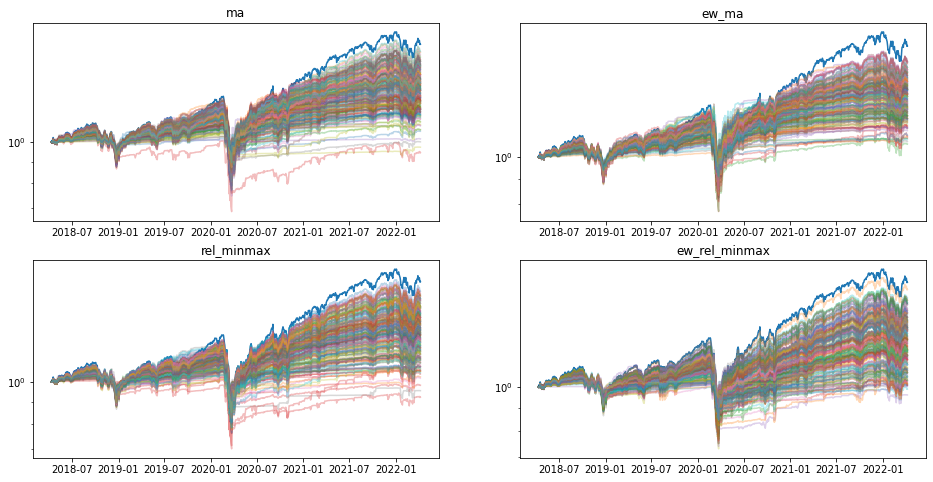

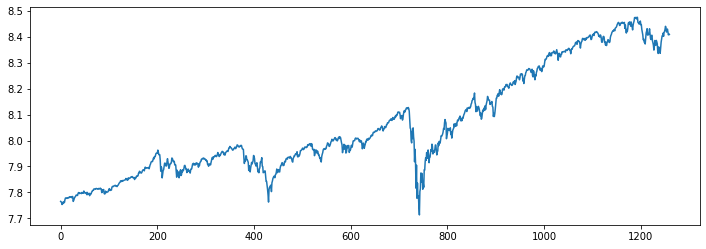

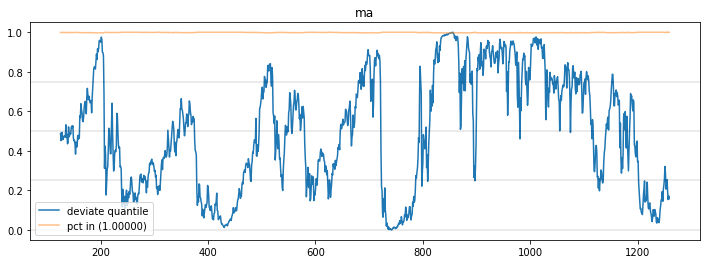

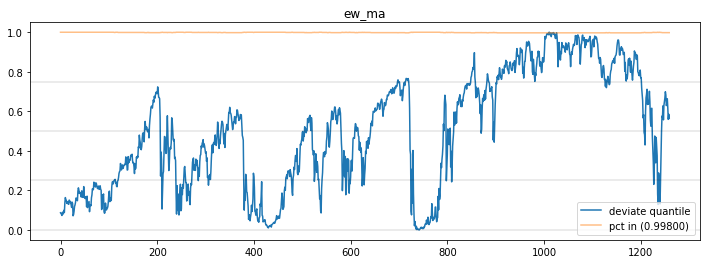

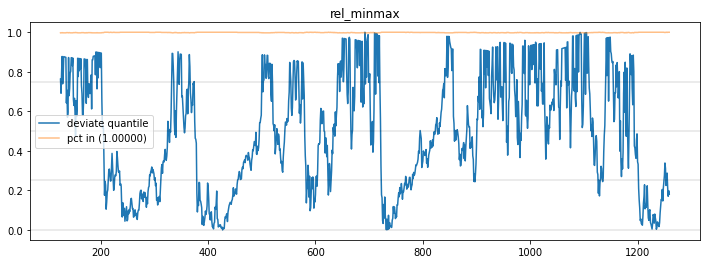

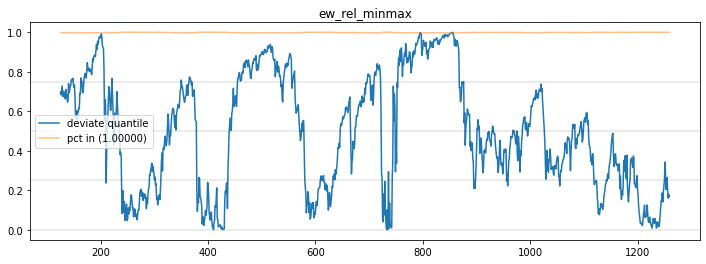

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.9395872441775175
Refitting current best...
Current best ma returns: 2.081429571178225
Fraction Invested: 0.9994134828897308
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.0814302587617073
Invested: 0.9999568046112787
New best: 2.083294708560862
Invested: 0.9999568046112787
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.9395872441775175
Refitting current best...
Current best ew_ma returns: 2.307807743308703
Fraction Invested: 0.9991898068914795
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.307907750463779
Invested: 0.9992616237401112
New bes

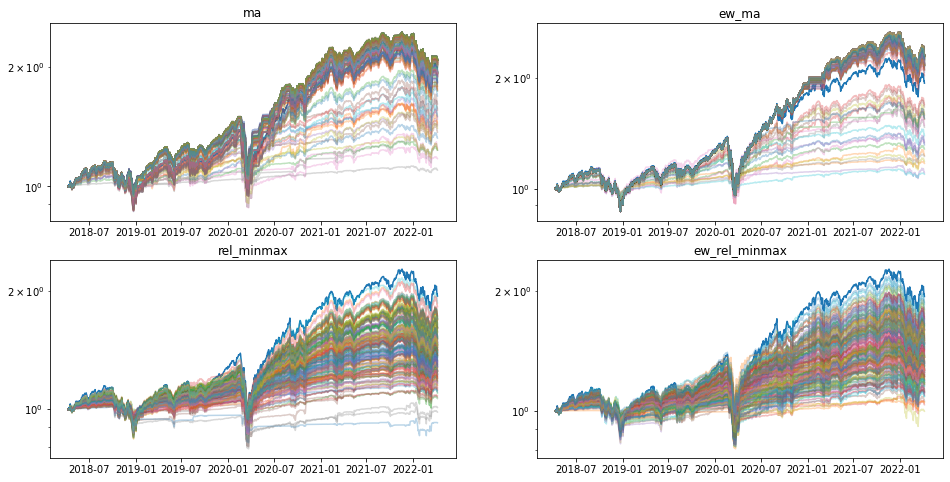

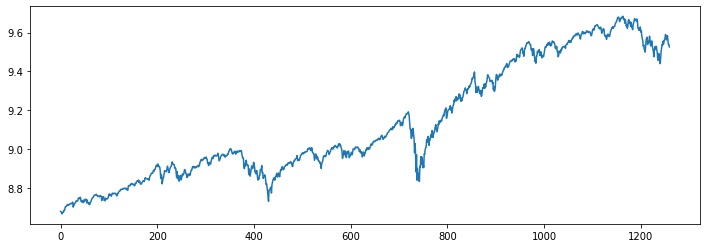

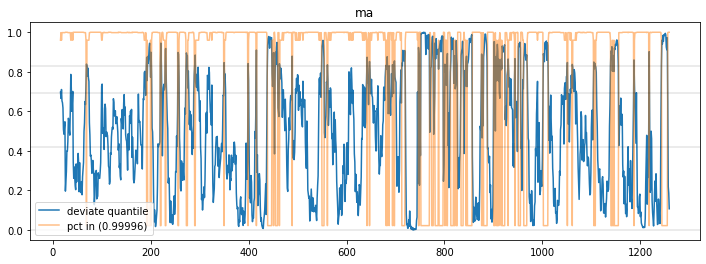

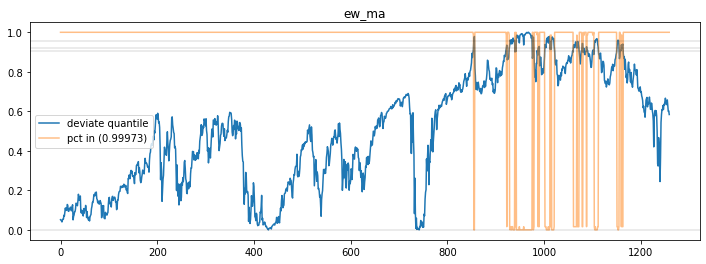

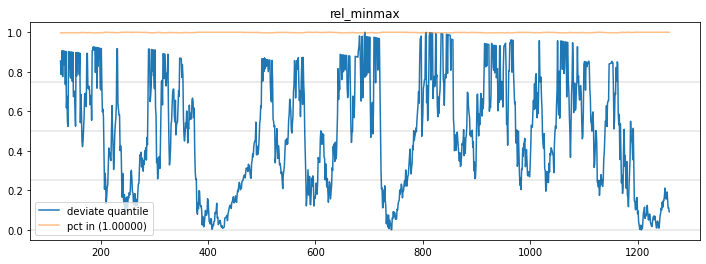

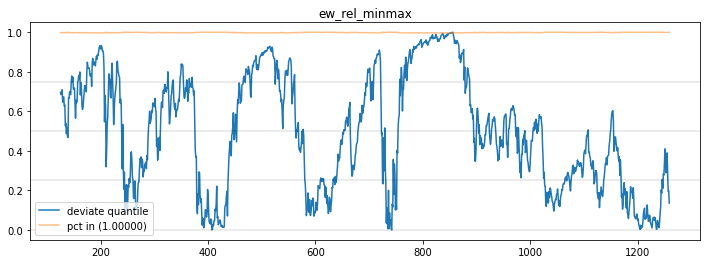

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.333639330344114
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.333639330344114
Refitting current best...
Current best ew_ma returns: 1.3339800925172869
Fraction Invested: 0.971276234962734
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.3461835592323594
Invested: 0.971276234962734
New best: 1.3510137042490127
Invested: 0.9936043935407315
New best: 1.351194987543252
Invested: 0.9936043935407315
New best: 1.3524738702657082
Invest

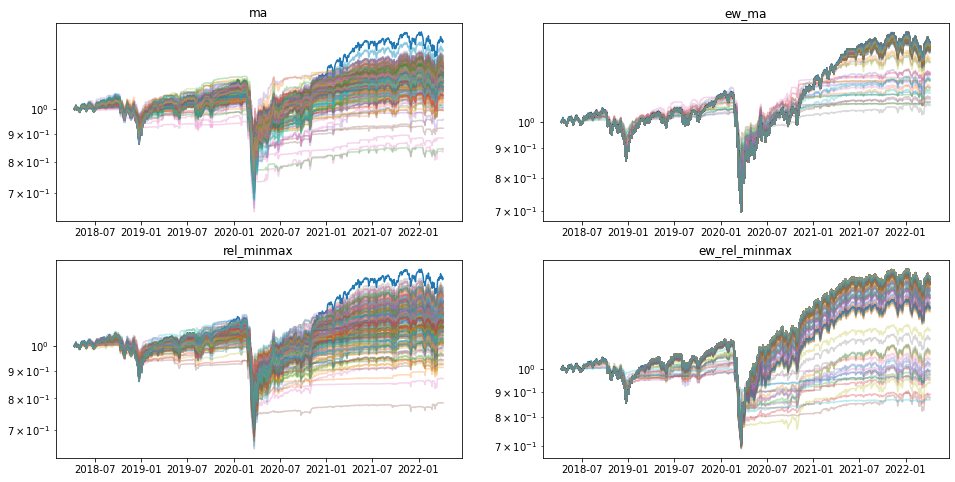

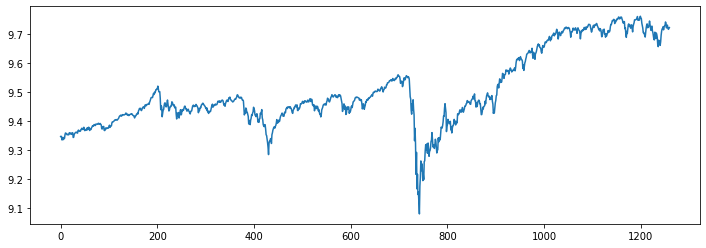

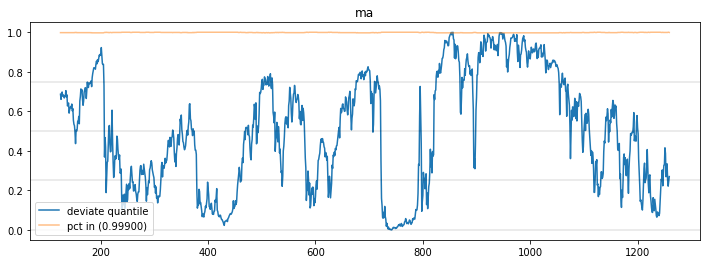

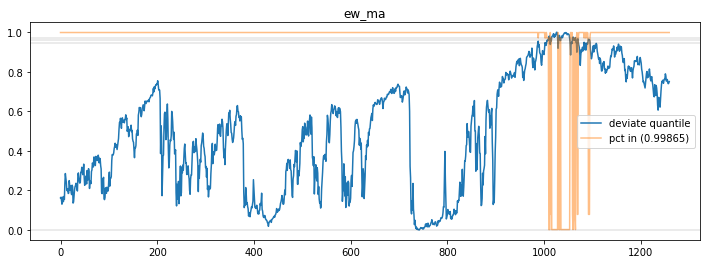

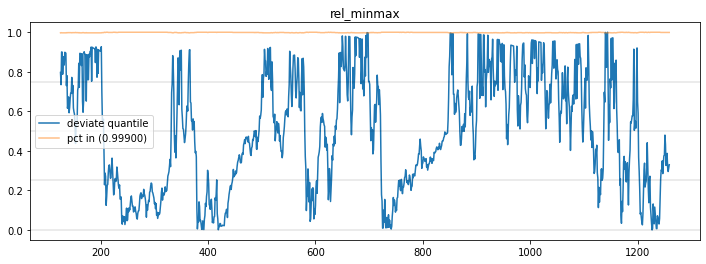

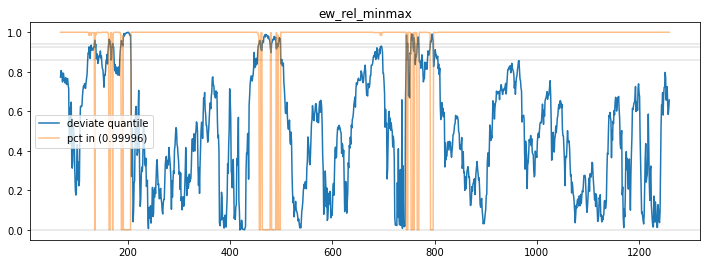

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6356459281832085
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6356459281832085
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 1.6356459281832085
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adj

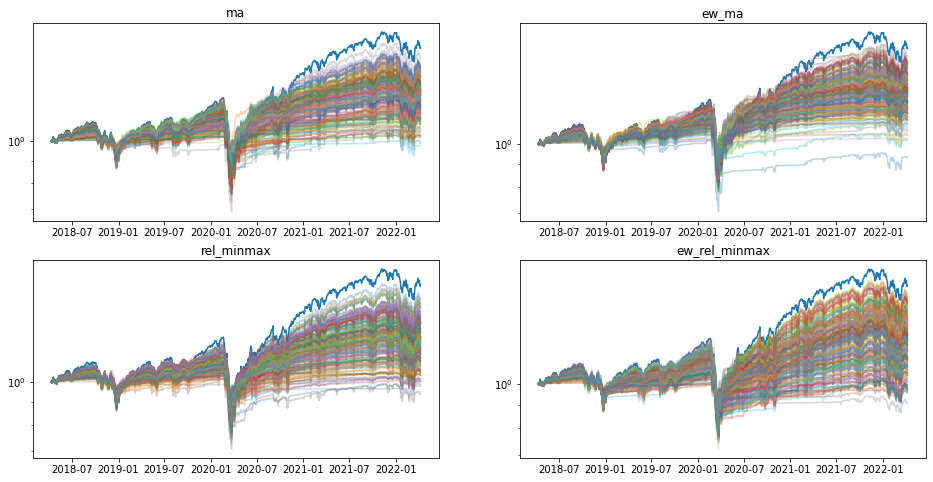

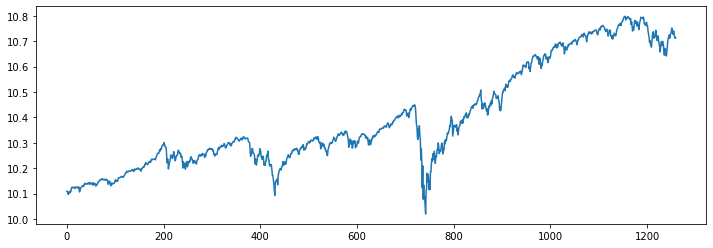

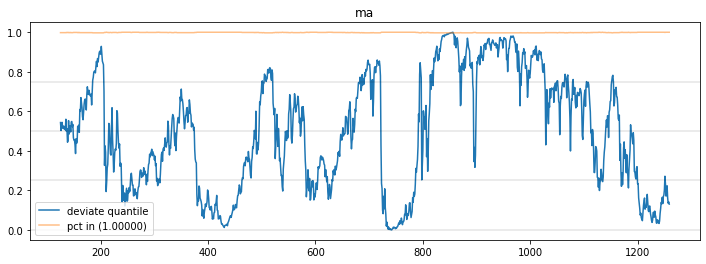

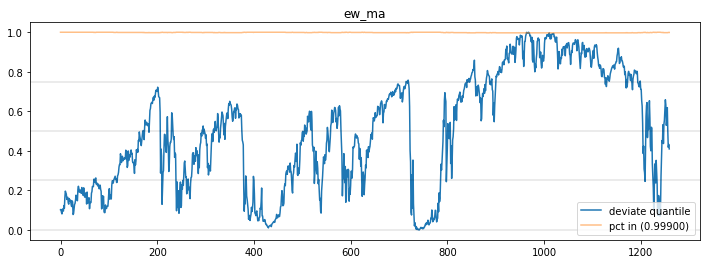

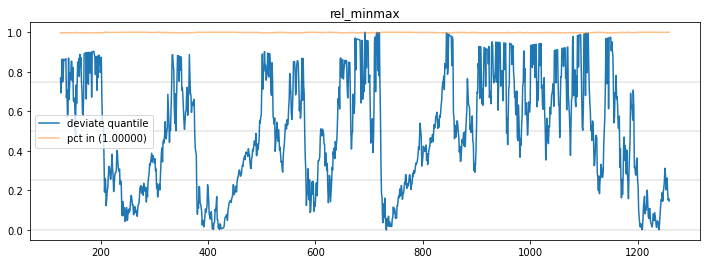

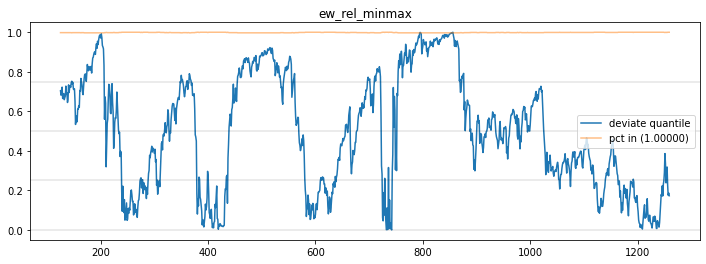

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.283302683231075
Refitting current best...
Current best ma returns: 5.284558889282432
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 5.284559034644098
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.283302683231075
Refitting current best...
Current best ew_ma returns: 4.699353497895117
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 4.6993690696009
Invested: 1.0
New best: 4.699551875761222
Invested: 1.0
New best: 4.69987815799226
Invested: 1.0
New best: 4.699908551309756
Invested: 1.0
New

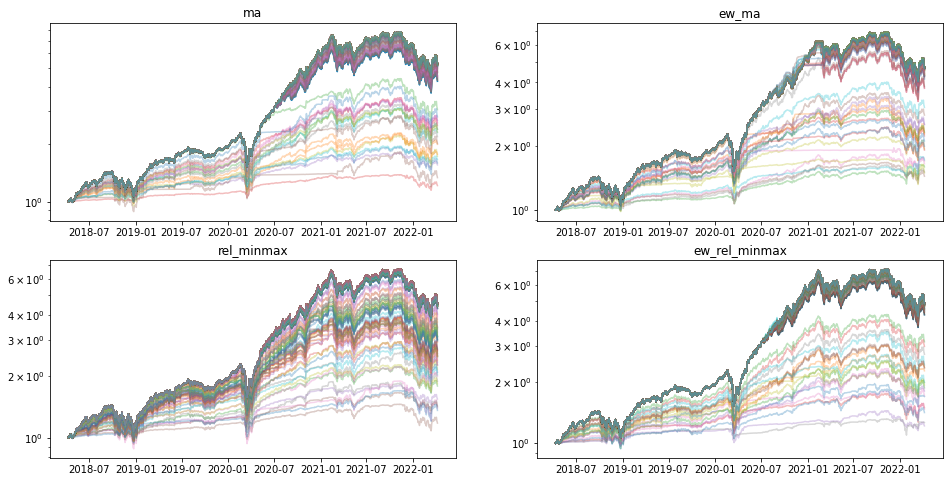

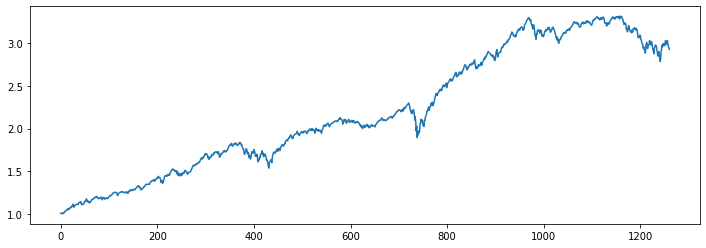

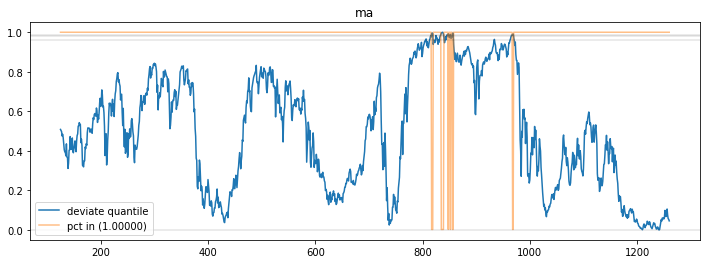

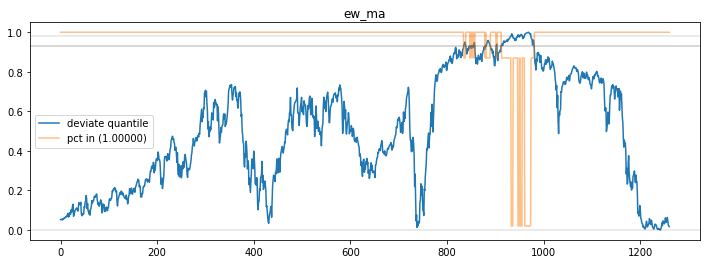

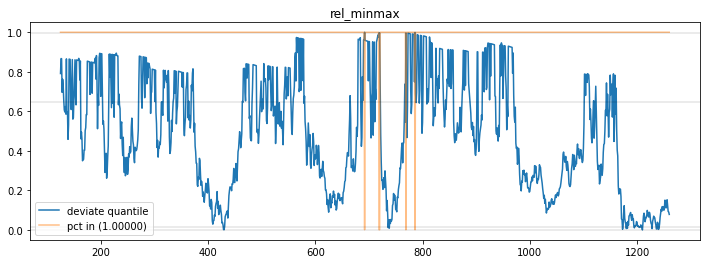

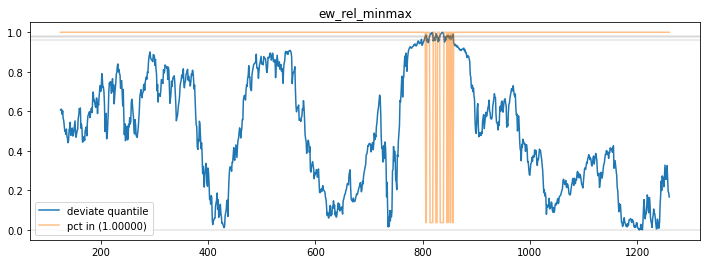

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.19173282614891
Refitting current best...
Current best ma returns: 2.663633595830232
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.66363462457357
Invested: 1.0
New best: 2.6636347958108715
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.19173282614891
Refitting current best...
Current best ew_ma returns: 3.075613273076499
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 3.07561327751339
Invested: 1.0
New best: 3.0756132891357355
Invested: 1.0
New best: 3.0806843581615113
Invested: 1.0




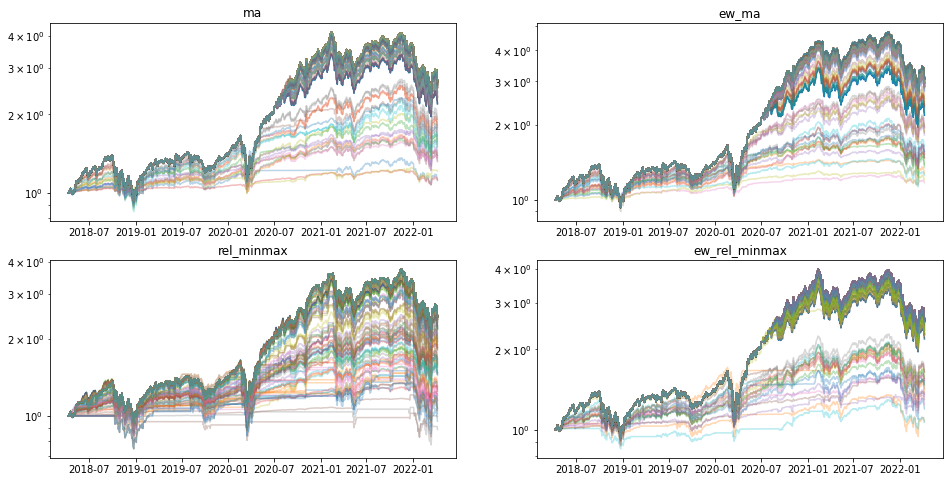

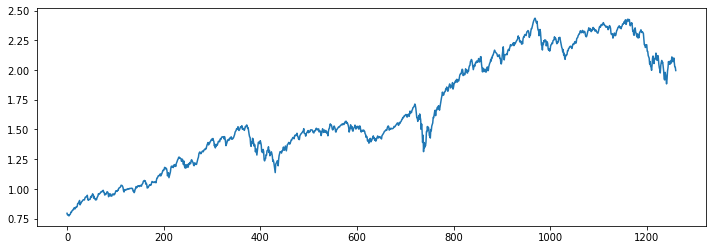

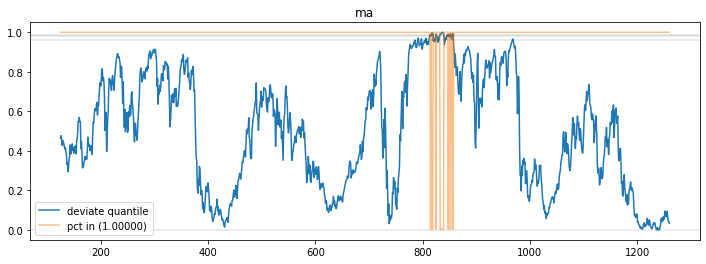

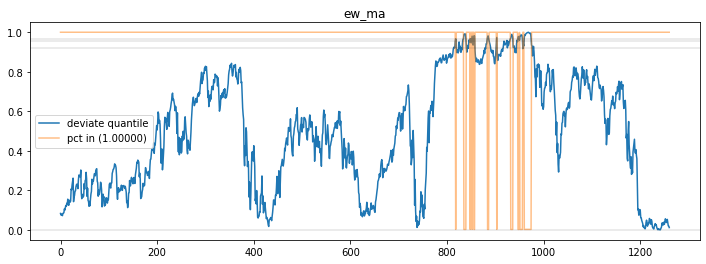

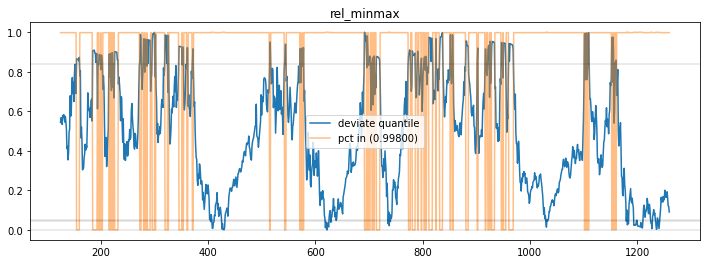

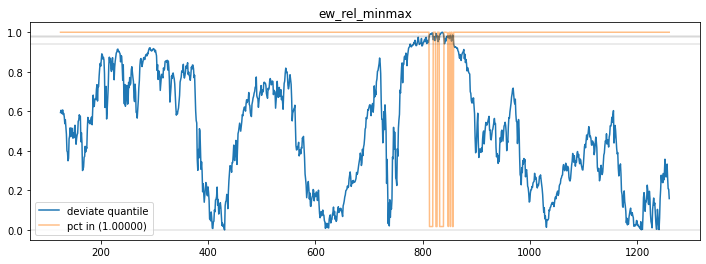

Saving mine2 params...


In [57]:
#N_RAND = 20
#N_ADJ = 180

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [71]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [72]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 1.6986968706600472 (ma)
  1.00000000 in
time param: 126
qs:
(0.0000 - 0.2500): 1.0000
(0.2500 - 0.5000): 0.9990
(0.5000 - 0.7500): 0.9980
(0.7500 - 1.0000): 0.9970

^IXIC:
  Best Return: 2.311800964547567 (ew_ma)
  0.99973020 in
time param: 247
qs:
(0.0000 - 0.9059): 0.9997
(0.9059 - 0.9203): 0.9856
(0.9203 - 0.9546): 0.0163
(0.9546 - 1.0000): 0.0003

^NYA:
  Best Return: 1.5323745334781318 (ew_rel_minmax)
  0.99996417 in
time param: 69
qs:
(0.0000 - 0.8585): 1.0000
(0.8585 - 0.9255): 0.9983
(0.9255 - 0.9395): 0.9839
(0.9395 - 1.0000): 0.0011

^W5000:
  Best Return: 1.6356459281832085 (ma)
  1.00000000 in
time param: 126
qs:
(0.0000 - 0.2500): 1.0000
(0.2500 - 0.5000): 0.9990
(0.5000 - 0.7500): 0.9980
(0.7500 - 1.0000): 0.9970

mine1:
  Best Return: 5.284559034644098 (ma)
  1.00000000 in
time param: 126
qs:
(0.0000 - 0.9621): 1.0000
(0.9621 - 0.9834): 1.0000
(0.9834 - 0.9883): 0.9996
(0.9883 - 1.0000): 0.0026

mine2:
  Best Return: 3.0806843581615113 (ew_ma)
  1.

{'^GSPC': {'best_return': 1.6986968706600472, 'pct_in': 1},
 '^IXIC': {'best_return': 2.311800964547567, 'pct_in': 0.99973019778187},
 '^NYA': {'best_return': 1.5323745334781318, 'pct_in': 0.9999641725001552},
 '^W5000': {'best_return': 1.6356459281832085, 'pct_in': 1},
 'mine1': {'best_return': 5.284559034644098, 'pct_in': 1.0},
 'mine2': {'best_return': 3.0806843581615113, 'pct_in': 1.0}}

In [73]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 1.6986968706600472, 'pct_in': 1, 'weight': 0},
 '^IXIC': {'best_return': 2.311800964547567,
  'pct_in': 0.99973019778187,
  'weight': 1.191903572003479},
 '^NYA': {'best_return': 1.5323745334781318,
  'pct_in': 0.9999641725001552,
  'weight': 1.1490172032364543},
 '^W5000': {'best_return': 1.6356459281832085, 'pct_in': 1, 'weight': 0},
 'mine1': {'best_return': 5.284559034644098,
  'pct_in': 1.0,
  'weight': 0.6168790096638388},
 'mine2': {'best_return': 3.0806843581615113,
  'pct_in': 1.0,
  'weight': 0.7027965090924372}}

In [74]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [75]:
!say qp is dunzo